## LightGBMのサンプルコード

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# LightGBM
import lightgbm as lgb

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 評価指標
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 前処理
from sklearn.preprocessing import StandardScaler

In [3]:
print(lgb.__version__)

3.1.1


In [4]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [5]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

# trainのデータセットの2割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [6]:
# LightGBMのパラメータ設定
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"rmse", "l2", "l1"},
    "num_leaves": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "vervose": 0,
}

In [7]:
# LightGBM学習

# 学習の経過を保存する箱
evaluation_results = {}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_names=["train", "valid"],
    valid_sets=[lgb_train, lgb_eval],
    evals_result=evaluation_results,
    early_stopping_rounds=50,
)

[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 13
[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Info] Start training from score 21.968731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's rmse: 8.78599	train's l1: 6.23168	train's l2: 77.1936	valid's rmse: 6.85125	valid's l1: 5.33386	valid's l2: 46.9396
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's rmse: 8.45773	train's l1: 5.96068	train's l2: 71.5332	valid's rmse: 6.58086	valid's l1: 5.12725	va

In [8]:
# LightGBM推論
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

In [9]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [10]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE      RMSE
scores  0.782247  3.091336  22.772769  4.772082


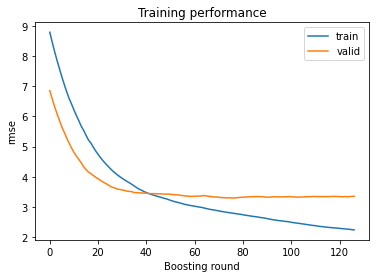

In [11]:
# 学習過程の可視化
plt.plot(evaluation_results["train"]["rmse"], label="train")
plt.plot(evaluation_results["valid"]["rmse"], label="valid")
plt.ylabel("rmse")
plt.xlabel("Boosting round")
plt.title("Training performance")
plt.legend()
plt.show()